Data Augmentation

In the previous lessons, we saw that having a high training accuracy does not automatically mean having a good predictive model. It can still perform poorly on the new data because it has overfit to the training set. In this notebook, we will see how to avoid that using `data augmentation`. This increases the amount of training data by modifying the existing training data's properties. For example, in image data, we can apply different preprocessing technqiues such as rotate, flip, shear, or zoom on our existing images so we can stimulate other data that the model should also learn from. This way, the model would see more variety in the images during training so it will better on new, previously unseen data.

Baseline Performance

We will start with a model that is very effective at leardning `Cats vs Dogs` without data augmentation. It is similar to the previous models that we have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively.

We will train only for 20 epochs to save time but feel free to increasse this if we want.

In [1]:
# # Download the dataset
# !wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

In [2]:
# import zipfile

# zip = zipfile.ZipFile('./cats_and_dogs_filtered.zip')
# zip.extractall()
# zip.close()

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# Assign training and validation dataset directories

base_dir = r'./cats_and_dogs_filtered/'
train_dir = os.path.join(base_dir, 'train')
train_dir_dogs = os.path.join(train_dir, 'dogs')
train_dir_cats =os.path.join(train_dir, 'cats')
validation_dir = os.path.join(base_dir, 'validation')
val_dir_dogs = os.path.join(validation_dir, 'dogs')
val_dir_cats = os.path.join(validation_dir, 'cats')


In [5]:
# Get the total number of images per classes under train_dir
len(os.listdir(train_dir_dogs)), len(os.listdir(train_dir_cats))

(1000, 1000)

In [6]:
# Get the total number of images per classes under validation_dir
len(os.listdir(val_dir_cats)), len(os.listdir(val_dir_dogs))

(500, 500)

In [7]:
target_img = os.listdir(train_dir_dogs)
target_img[:5]

['dog.469.jpg', 'dog.338.jpg', 'dog.729.jpg', 'dog.765.jpg', 'dog.663.jpg']

In [8]:
train_dir

'./cats_and_dogs_filtered/train'

In [9]:
classes = os.listdir(train_dir)
classes

['dogs', 'cats']

In [10]:
train_dir + '/' + classes[0]

'./cats_and_dogs_filtered/train/dogs'

In [11]:
os.listdir(train_dir + '/' + classes[0])[:5]

['dog.469.jpg', 'dog.338.jpg', 'dog.729.jpg', 'dog.765.jpg', 'dog.663.jpg']

In [12]:
random.choice(os.listdir(train_dir + '/' + classes[0])[:5])

'dog.765.jpg'

Random Directory is ./cats_and_dogs_filtered/train/dogs of dog.648.jpg file.


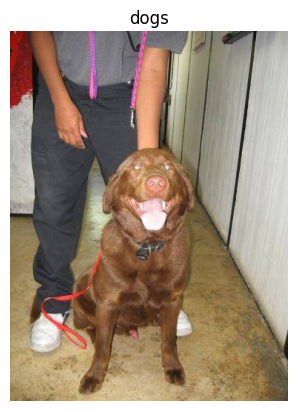

In [13]:
# Create a random directory (dogs)

r_dir = train_dir + '/' + classes[0]
r_dir_= random.choice(os.listdir(r_dir))
print(f"Random Directory is {r_dir} of {r_dir_} file.")

# Read in the file (dogs)
img = mpimg.imread(r_dir + '/'+ r_dir_)
plt.imshow(img)
plt.title(classes[0])
plt.axis("off");

Random Directory is ./cats_and_dogs_filtered/train/cats of cat.171.jpg file.


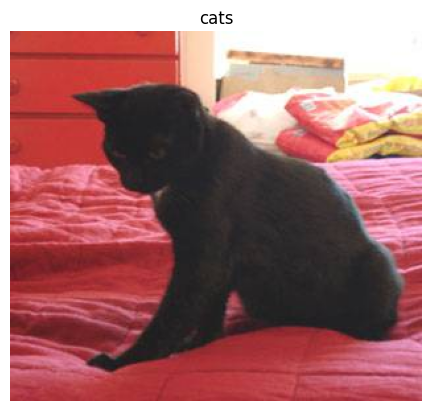

In [14]:
# Create a random directory (cats)

r_dir = train_dir + '/' + classes[1]
r_dir_= random.choice(os.listdir(r_dir))
print(f"Random Directory is {r_dir} of {r_dir_} file.")

# Read in the file (dogs)
img = mpimg.imread(r_dir + '/'+ r_dir_)
plt.imshow(img)
plt.title(classes[1])
plt.axis("off");

We will place the model creation inside a function so we can easily initialize a new one when we use data augmentation later in this notebook.

Create a TensorFlow model

In [15]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model

2023-08-02 20:47:55.173755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 20:47:55.205886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-02 20:47:55.206859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 20:47:55.616043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/20


2023-08-02 20:47:56.397639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-02 20:47:56.397857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


100/100 - 14s - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6836 - val_accuracy: 0.6060 - 14s/epoch - 141ms/step
Epoch 2/20
100/100 - 13s - loss: 0.6770 - accuracy: 0.5775 - val_loss: 0.6553 - val_accuracy: 0.6300 - 13s/epoch - 134ms/step
Epoch 3/20
100/100 - 13s - loss: 0.6506 - accuracy: 0.6140 - val_loss: 0.6279 - val_accuracy: 0.6720 - 13s/epoch - 132ms/step
Epoch 4/20
100/100 - 13s - loss: 0.6117 - accuracy: 0.6675 - val_loss: 0.6084 - val_accuracy: 0.6720 - 13s/epoch - 129ms/step
Epoch 5/20
100/100 - 13s - loss: 0.5730 - accuracy: 0.6995 - val_loss: 0.6455 - val_accuracy: 0.6430 - 13s/epoch - 129ms/step
Epoch 6/20
100/100 - 13s - loss: 0.5534 - accuracy: 0.7155 - val_loss: 0.5736 - val_accuracy: 0.7040 - 13s/epoch - 131ms/step
Epoch 7/20
100/100 - 13s - loss: 0.5345 - accuracy: 0.7295 - val_loss: 0.5920 - val_accuracy: 0.6850 - 13s/epoch - 130ms/step
Epoch 8/20
100/100 - 13s - loss: 0.5103 - accuracy: 0.7535 - val_loss: 0.5651 - val_accuracy: 0.7060 - 13s/epoch - 128ms/step
Epo

We will then visualize the loss and accuracy with respect to the training and validation set. We will again use a convenience function so it can be reused later. This function accepts a `History` object which contains the results of the fit() method we ran above.

In [18]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

From the results above, we'll see the training accuracy is more than 90%, and the validation accuracy is in the 70%-80% range. This is a great example of overfitting -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't.

### Data Augmentation

One simple method to avoid overfitting is to augment the images a bit. If we think about it, most pictures of a cat are very similar -- the ears are at the top, then the eyes, then the mouth etc. Things like the distance between the eyes and ears will always be quite similar too.

What if we will tweak with the images a bit -- rotate the image, squash it, etc. That's what image augementation is all about. And there's an API that makes it easy!

Take a look at the ImageDataGenerator which we have been using to rescale the image. There are other properties on it that we can use to augment the image.

### Updated to do image augmentation
train_datagen = ImageDataGenerator( \
      rotation_range=40, \
      width_shift_range=0.2, \
      height_shift_range=0.2,\
      shear_range=0.2,\
      zoom_range=0.2,\
      horizontal_flip=True,\
      fill_mode='nearest')\
      
These are just a few of the options available.\
Let's quickly go over it:

rotation_range is a value in degrees (0–180) within which to randomly rotate pictures.
width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
shear_range is for randomly applying shearing transformations.
zoom_range is for randomly zooming inside pictures.
horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
Run the next cells to see the impact on the results. The code is similar to the baseline but the definition of train_datagen has been updated to use the parameters described above.

In [19]:
# Create new model
model_for_aug = create_model()

# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Train the new model
history_with_aug = model_for_aug.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 - 14s - loss: 0.6927 - accuracy: 0.5280 - val_loss: 0.6866 - val_accuracy: 0.5000 - 14s/epoch - 144ms/step
Epoch 2/20
100/100 - 14s - loss: 0.6870 - accuracy: 0.5400 - val_loss: 0.6780 - val_accuracy: 0.5800 - 14s/epoch - 138ms/step
Epoch 3/20
100/100 - 14s - loss: 0.6780 - accuracy: 0.5715 - val_loss: 0.6499 - val_accuracy: 0.6330 - 14s/epoch - 136ms/step
Epoch 4/20
100/100 - 14s - loss: 0.6652 - accuracy: 0.5890 - val_loss: 0.6828 - val_accuracy: 0.5280 - 14s/epoch - 138ms/step
Epoch 5/20
100/100 - 14s - loss: 0.6542 - accuracy: 0.6065 - val_loss: 0.6264 - val_accuracy: 0.6690 - 14s/epoch - 141ms/step
Epoch 6/20
100/100 - 14s - loss: 0.6425 - accuracy: 0.6170 - val_loss: 0.6120 - val_accuracy: 0.6490 - 14s/epoch - 139ms/step
Epoch 7/20
100/100 - 14s - loss: 0.6253 - accuracy: 0.6415 - val_loss: 0.5770 - val_accuracy: 0.6950 - 14s/epoch - 137ms/step
Epoch 8/20
100/100 - 14s - loss: 0

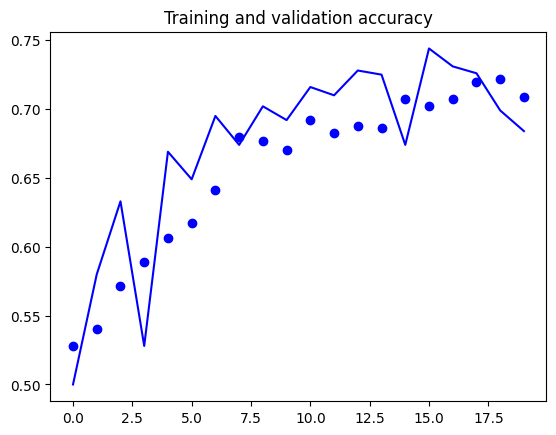

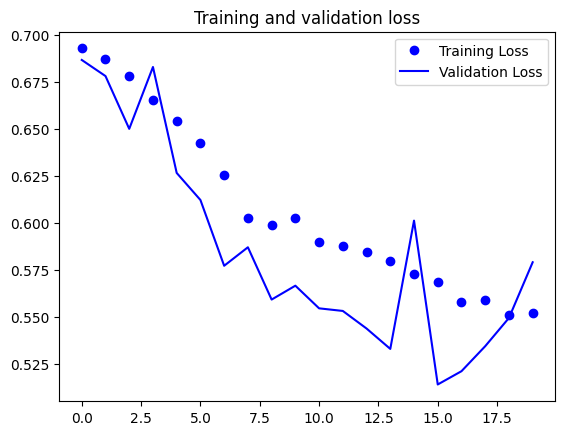

In [20]:
# Plot the results of training with data augmentation
plot_loss_acc(history_with_aug)

As we can see, the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.

### Wrap Up
This exercise showed a simple trick to avoid overfitting. We can improve our baseline results by simply tweaking the same images we have already. The ImageDataGenerator class has built-in parameters to do just that. Try to modify the values some more in the train_datagen and see what results we get.

Take note that this will not work for all cases. In the next lesson, Laurence will show a scenario where data augmentation will not help improve our validation accuracy